# **Final Project in Integrated Energy Grids - 46770**

# PROJECT INSTRUCTIONS


Based on the previous example, you are asked to carry out the following tasks:

# A.:

- Choose a different country/region/city/system and calculate the optimal capacities for renewable and non-renewable generators.
- Add multiple technologies and provide references for the cost assumptions.
- Plot the dispatch time series for a week in summer and winter.
- Plot the annual electricity mix.
- Use the duration curves or the capacity factor to investigate the contribution of different technologies.

In [1]:
 # Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import gurobipy as gp

import functions as f # This includes e.g. annuity

In [2]:
# Initialize network and define snapshots
network = pypsa.Network()

year = '2015' # only 2015 is valid for the demands (electricity AND heat)
country = 'GBR' # All EU countries are valid?

hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                              f'{year}-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_year.values)

network.add("Bus",
            f"{country} electricity bus")

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

In [3]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    29059.0
2015-01-01 01:00:00+00:00    28663.0
2015-01-01 02:00:00+00:00    26626.0
2015-01-01 03:00:00+00:00    24778.0
2015-01-01 04:00:00+00:00    23212.0
Name: GBR, dtype: float64


In [4]:
# add load to the bus
network.add("Load",
            f"{country} electricity load",
            carrier="electricity",
            bus=f"{country} electricity bus",
            p_set=df_elec[country].values,
            overwrite=True)

type(df_elec[country]),df_elec[country].values.shape

(pandas.core.series.Series, (8760,))

In [5]:
network.loads_t.p_set

Load,GBR electricity load
snapshot,
2015-01-01 00:00:00,29059.0
2015-01-01 01:00:00,28663.0
2015-01-01 02:00:00,26626.0
2015-01-01 03:00:00,24778.0
2015-01-01 04:00:00,23212.0
...,...
2015-12-31 19:00:00,35944.0
2015-12-31 20:00:00,33128.0
2015-12-31 21:00:00,30488.0


In [6]:
# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

# load solar data
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

# Defining some lists and a dict that is used so make model building and visualization dynamic
VRE_techs = ['onshorewind', 'solar']
CF_dict = {'onshorewind': CF_wind, 'solar': CF_solar}
techs_labels = ['onshorewind', 'solar', 'OCGT', 'coal', 'nuclear', 'biomass'] # NG plant = natural gas plant
carriers = ['onshorewind', 'solar', 'gas', 'coal', 'nuclear', 'wood chips']
techs_colors = ['blue', 'orange', 'brown', 'grey', 'purple', 'green']

In [7]:
''' Define data needed to setup the generators in the Pypsa network '''

''' unit conversion constants and universal constants'''
dollar2euro = 0.9239 # [€/$] -- https://www.valutakurser.dk - 25/03-25
lbs2kg = 0.453592 # [kg/lbs] multiply by this to go from lbs/kWh to kg/kWh
kJ2MWh = 1/(10**3 * 60**2) # [MWh/kJ]
MMBtu2MWh = 0.293 # [MWh / MMBtu]
coal_energy_density = 24 / 60**2 * 10**3 # [MJ/kg] -> [MWh/t]
'''
# From Teknologikataloget (Version 2025: 2030-values): https://ens.dk/analyser-og-statistik/teknologikatalog-produktion-af-el-og-fjernvarme, pp. 209, 260, and 361/371 
    # technology: wind, solar, OCGT, coal, biomass
    # metric:     capital costs(wind, solar, OCGT, biomass), efficiencies (OCGT, biomass), lifetime

# https://iopscience.iop.org/article/10.1088/1748-9326/11/11/114010/meta -- their gas numbers match ours nicely
    # technology: coal
    # metric:     capital costs

# https://ourworldindata.org/grapher/coal-prices
    # technology: coal
    # metric:     fuel costs

# https://ourworldindata.org/grapher/natural-gas-prices
    # technology: gas
    # metric:     fuel costs
'''
gas_price_index_ratio_2023_2016 = 275.58/104.13 # drastic changes ¿primarily due to Russian invasion of Ukraine?
coal_price_index_ratio_2023_2016 = 215.30/99.87

'''
# https://www.gevernova.com/gas-power/resources/articles/2018/come-hele-or-high-water
    # technology: coal
    # metric:     efficiency

# https://www.sciencedirect.com/science/article/pii/S1364032121001301
    # technology: nuclear
    # metric:     capital costs, fuel/variable costs

# https://www.iaea.org/sites/default/files/29402043133.pdf
    # technoklogy: nuclear
    # metric:      lifetime

# https://www.sciencedirect.com/science/article/pii/S0196890422001297?via%3Dihub
    # technology: biomass
    # metric:     fuel costs
    # the price is given as 41 $/tonne and LHV in kJ/kg, so the conversion is a little tricky as may be noticed below
'''
lifetimes = [30, 25, 25, 15, 40, 25] # years

capital_costs = np.array([1.333, 0.26, 0.435, 1.75, 9, 3.1]) * 10**6 # €/MW, originally in M€/MW, pp. 209,260,371
'''# https://backend.orbit.dtu.dk/ws/portalfiles/portal/158807620/OffshoreOnshore_Energy_Policy_August_revision_28_8.pdf
    # More optimistic onshore wind capital costs -- without these the results are still interesting, though'''
#capital_costs[0] = 0.8e6
dict_capital_costs_annualized = {tech:f.annuity(lifetime, 0.07)*cost*(1+0.03) for tech,cost,lifetime in zip(techs_labels,capital_costs,lifetimes)}

efficiencies = np.array([1, # [MW_e/MW_th]
                         1,
                         0.43,
                         0.4,
                         1,
                         0.305])
dict_efficiencies = {tech:eff for tech,eff in zip(techs_labels, efficiencies)}

gas_co2_emissions = 52.91/10**3 # kg_CO2/kWh_th -> t_CO2/kWh_th -- from https://www.eia.gov/environment/emissions/co2_vol_mass.php
coal_co2_emissions = 95.99/10**3 # kg_CO2/kWh_th -> t_CO2/kWh_th

fuel_costs_dollars = np.array([0,  # -,-,$/MWh_th, $/MWh_th, $/MWh_e, $/MWh_th
                               0,
                               41.97, 
                               129.54/coal_energy_density, # $/t -> $/MWh_th 
                               10.11,
                               41/10**3/19970 / kJ2MWh]) # originally 41 $/tonne, HHV=19970 kJ/kg
fuel_costs = (fuel_costs_dollars
              * np.array([0, 0, dollar2euro, dollar2euro, dollar2euro, dollar2euro])) # €/MWh_th, MWh_e for nuclear
dict_fuel_costs = {tech:cost for tech,cost in zip(techs_labels, fuel_costs)}

dict_marginal_costs = {tech:dict_fuel_costs[tech] / dict_efficiencies[tech] for tech in techs_labels} # €/MWh_e

CO2_emissions = [0, # CO2_emissions [kgCO2/kWh_th=tCO2/MWh_th] for each carrier
                 0,
                 gas_co2_emissions/MMBtu2MWh,
                 coal_co2_emissions/MMBtu2MWh,
                 0,
                 0]  # biomass is assumed to be sourced sustainably...
network.add("Carrier", carriers, color=techs_colors, co2_emissions=CO2_emissions, overwrite=True)

Index(['onshorewind', 'solar', 'gas', 'coal', 'nuclear', 'wood chips'], dtype='object')

In [8]:
'''Only five objects are needed to dynamically define the generators:'''
#techs_labels
#carriers
#dict_capital_costs_annualized
#dict_marginal_costs
CFs = [CF_wind, CF_solar]

###################################
'''To get the same results as in the example from the assignment description, use these values INSTEAD:'''
''' There may be a few other lines in the code that should also be commented out, e.g. any lines including "biomass" '''
# techs_labels=["onshorewind", "solar", "OCGT"]
# carriers=["onshorewind", "solar", "gas"]

# capital_cost_onshorewind = f.annuity(30,0.07)*910000*(1+0.033) # in €/MW
# capital_cost_solar = f.annuity(25,0.07)*425000*(1+0.03) # in €/MW
# capital_cost_OCGT = f.annuity(25,0.07)*560000*(1+0.033) # in €/MW
# dict_capital_costs_annualized = {tech:val for tech,val in zip(techs_labels,[capital_cost_onshorewind,capital_cost_solar,capital_cost_OCGT])}

# fuel_cost = 21.6 # in €/MWh_th
# efficiency = 0.39 # MWh_elec/MWh_th
# marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
# dict_marginal_costs = {tech:val for tech,val in zip(techs_labels, [0,0,marginal_cost_OCGT])}

# network.generators.efficiency.loc["OCGT"] = efficiency
# network.add("Carrier", carriers, co2_emissions=[0,0,0.19], overwrite=True) # t_CO2/MWh_th
###################################

''' Dynamically define each generator in the Pypsa network '''
for i,tech in enumerate(techs_labels):
    network.add("Generator",
                tech,
                bus=f"{country} electricity bus",
                p_nom_extendable=True,
                carrier=carriers[i],
                capital_cost = dict_capital_costs_annualized[tech],
                marginal_cost = dict_marginal_costs[tech],
                p_max_pu = (CFs[i].values if tech in VRE_techs else 1),
                efficiency = dict_efficiencies[tech],
                overwrite=True) # kept  in case of re-running the code


In [9]:
network.generators_t.p_max_pu

Generator,onshorewind,solar
snapshot,,
2015-01-01 00:00:00,0.606,0.0
2015-01-01 01:00:00,0.610,0.0
2015-01-01 02:00:00,0.592,0.0
2015-01-01 03:00:00,0.570,0.0
2015-01-01 04:00:00,0.552,0.0
...,...,...
2015-12-31 19:00:00,0.508,0.0
2015-12-31 20:00:00,0.426,0.0
2015-12-31 21:00:00,0.336,0.0


In [10]:
network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshorewind,GBR electricity bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,GBR electricity bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
OCGT,GBR electricity bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
coal,GBR electricity bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
nuclear,GBR electricity bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
biomass,GBR electricity bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [11]:
# The constraint for sustainable biomass can be defined from e.g. the two approaches below.
    # a) Using a 2024 UK report on bioenergy
    # b) Using a 2024 EU report on bioenergy in Europe
# a):
# We limit the use of wood chips by:
# 1) assuming that all solid biomass is wood chips
# 2) assuming that all internally produced biomass (60% of solid biomass consumption) is sustainable and all imported is not and thus forbidden
# 3) assuming that the 294 PJ of solid biomass used for power is in thermal/raw units (MWh_h)
# The values above are for the UK and are from: from https://www.ieabioenergy.com/wp-content/uploads/2024/12/CountryReport2024_UK_final.pdf 
'''
PJ2MWh = 10**9 / 60**2
biomass_imported = 0.4
biomass_available = 294 * PJ2MWh * (1-biomass_imported)  # MWh_th
'''
# b):
# more DYNAMIC approach because then any EU country (incl. GBR, or NOR) can be used:
    # We limit the use of wood chips by:
    # 1) assuming that all solid biomass is wood chips. Simply referred to as "biomass" in script.
    # 2) assuming that all internally produced solid biomass (97.5% of solid biomass consumption) is sustainable and all imported is not and thus forbidden
    # 3) assuming that the 4.2 EJ of solid biomass is in thermal/raw units (MWh_h)
    # Using 2024 numbers from https://www.ieabioenergy.com/wp-content/uploads/2025/01/CountryReport2024_EU27_final_v2.pdf
EJ2MWh = 10**12 / 60**2  # purely unit conversion factor
biomass_imported_EU = 0.025
biomass_available_EU = 4.2 * EJ2MWh * (1-0.025)  # MWh_th
# We assume that biomass has the same potential to grow anywhere in Europe and so the EU numbers 
#   can be used to determine a biomass per land area-factor by weighting the country sizes
country_sizes = pd.read_csv('country_sizes.csv')
country_sizes.index = country_sizes['code']
biomass_density = biomass_available_EU / country_sizes['area'][country_sizes['EU']==True].sum()  # MWh/km2
biomass_available = biomass_density * country_sizes.loc[country]['area'].sum()  # MWh


network.carriers["track_biomass"] = [0, 0, 0, 0, 0, 1.0]  # count 1 MWh for each MWh of wood chips used and none for the others

network.add(
    "GlobalConstraint",
    "BiomassLimit",
    carrier_attribute="track_biomass",
    sense="<=",
    constant=biomass_available,
    overwrite=True
)
network.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth,track_biomass
Carrier,,,,,,
onshorewind,0.000000,blue,,inf,0.0,0.0
solar,0.000000,orange,,inf,0.0,0.0
gas,0.180580,brown,,inf,0.0,0.0
coal,0.327611,grey,,inf,0.0,0.0
nuclear,0.000000,purple,,inf,0.0,0.0
wood chips,0.000000,green,,inf,0.0,1.0


In [42]:
biomass_available/1e6

66.92815183042231

In [12]:
env = gp.Env(empty=True) # Initialize a gurobipy-environment in which we can disable unnecessary outputs
env.setParam("OutputFlag", 0)  # Fully disable output
env.start()

network.optimize(solver_name='gurobi', solver_options={"env": env})

Index(['GBR electricity load'], dtype='object', name='Load')
Index(['GBR electricity bus'], dtype='object', name='Bus')
Index(['GBR electricity load'], dtype='object', name='Load')
Index(['GBR electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.88it/s]
INFO:linopy.io: Writing time: 0.98s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.83e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [13]:
print(network.objective / 10**9 ) #in 10^9 €

18.283725722035733


In [14]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
GBR electricity load    64.791061
dtype: float64


In [15]:
network.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind    36.702830
solar          71.145456
OCGT           30.502057
coal           17.361689
nuclear         0.000000
biomass         2.728113
Name: p_nom_opt, dtype: float64

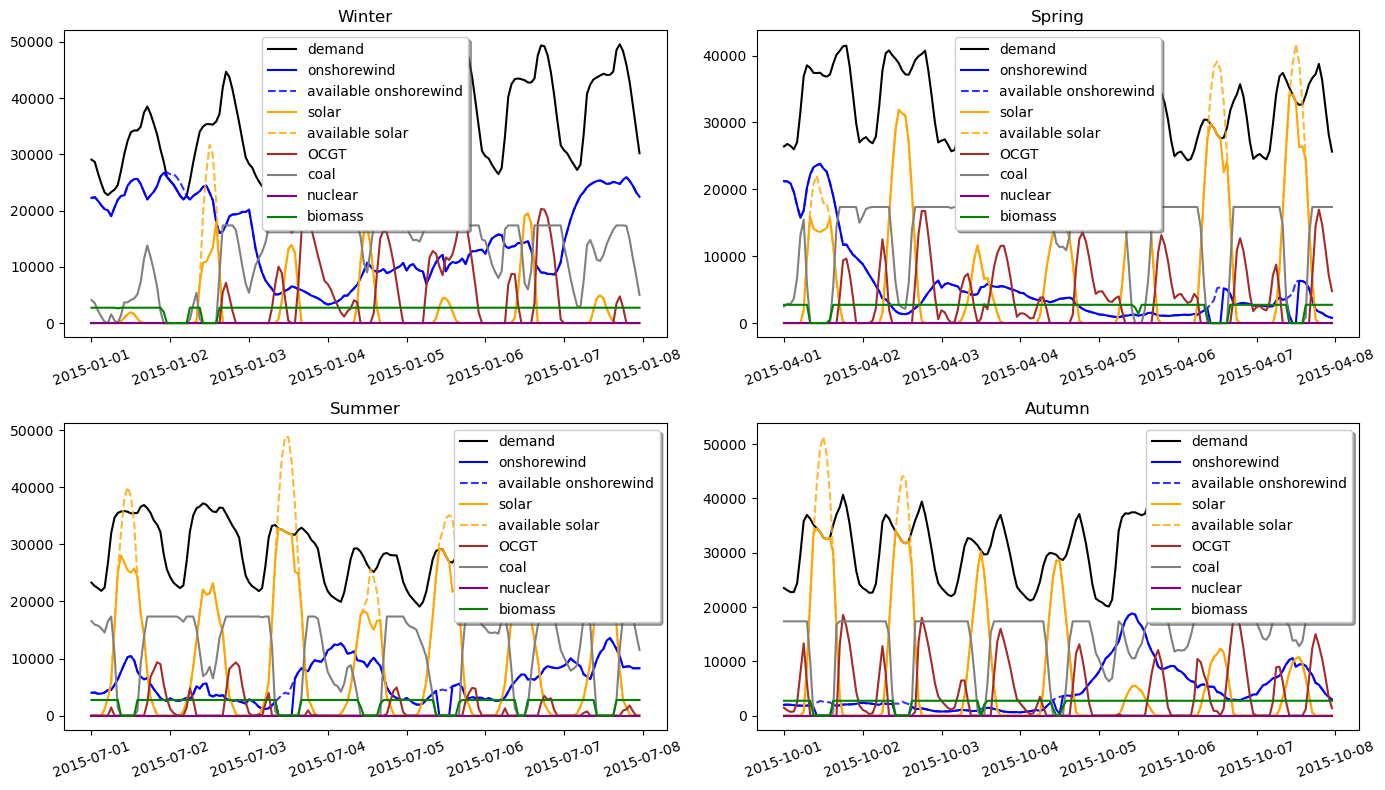

In [16]:
import matplotlib.pyplot as plt

seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
start_index = np.array([0, 24*90, 24*181, 24*273]) # 1st of Jan/Apr/Jul/Oct
end_index = start_index + 24*7 # add a week to each of the indexes


fig, ax = plt.subplots(2,2, figsize=(14,8))
ax=ax.flatten()

for i,season in enumerate(seasons):
    ax[i].plot(network.loads_t.p[f'{country} electricity load'][start_index[i]:end_index[i]],
               color='black',
               label='demand')
    for tech, color in zip(techs_labels, techs_colors):
        ax[i].plot(network.generators_t.p[tech][start_index[i]:end_index[i]],
                   color=color,
                   label=tech)
        if tech in VRE_techs:
            ax[i].plot(network.generators.p_nom_opt[tech] * CF_dict[tech][start_index[i]:end_index[i]],
                       color=color,
                       alpha=0.8,
                       linestyle='--',
                       label=f'available {tech}')
    ax[i].set_title(season)
    ax[i].legend(fancybox=True, shadow=True, loc='best', prop={'size': 10})
    ax[i].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

Text(0.5, 1.07, 'Electricity mix')

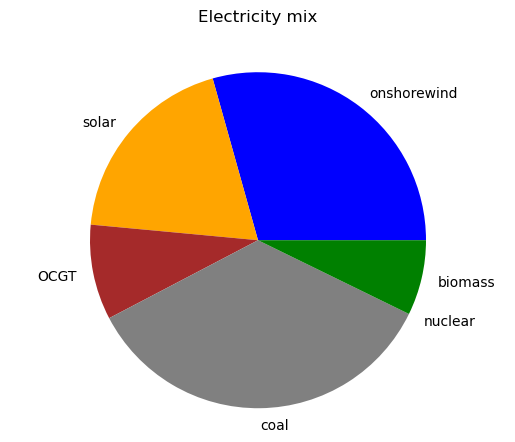

In [17]:
sizes = [network.generators_t.p[tech].sum()
         for tech in techs_labels]

plt.pie(sizes,
        colors=techs_colors,
        labels=techs_labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [18]:
np.array(sizes) / 10**6, biomass_available / 10**6 * dict_efficiencies['biomass'] # in TWh. Compare the biomass used to the biomass available to verify if we are using everything

(array([82.82397405, 54.09583974, 25.84606421, 99.0162247 ,  0.        ,
        20.41308631]),
 20.413086308278803)

In [19]:
# Generator revenues
network.generators_t.p.multiply(network.buses_t.marginal_price.to_numpy()).sum().div(1e6) # € -> M€

Generator
onshorewind    4060.959914
solar          1634.926595
OCGT           3503.443749
coal           7879.884421
nuclear           0.000000
biomass        1451.887355
dtype: float64

In [20]:
# Total expenditures by carriers
( network.statistics.capex(groupby="carrier").add(
    network.statistics.opex(groupby="carrier"), fill_value=0
    )
).div(1e6) # € -> M€

component  carrier    
Generator  coal           7879.884421
           gas            3503.443749
           onshorewind    4060.959914
           solar          1634.926595
           wood chips     1204.511042
dtype: float64

The coal expenditures do not match the coal revenues since the installed coal capacity was not a part of the optimization problem.

Nor do the biomass expenditures because of the sustainable biomass constraint.

In [21]:
# emissions by GENERATOR
emissions = (
    network.generators_t.p
    / network.generators.efficiency
    * network.generators.carrier.map(network.carriers.co2_emissions)
)  # t/h
emissions.sum().div(1e6)  # tCO2 -> MtCO2

Generator
onshorewind     0.000000
solar           0.000000
OCGT           10.854157
coal           81.096992
nuclear         0.000000
biomass         0.000000
dtype: float64

In [22]:
# emissions by CARRIER
emissions = (
    network.generators_t.p
    / network.generators.efficiency
    * network.generators.carrier.map(network.carriers.co2_emissions)
).T.groupby(network.generators.carrier).sum().T  # t/h
emissions.sum().div(1e6), emissions.sum().div(1e6).sum()  # tCO2 -> MtCO2

(carrier
 coal           81.096992
 gas            10.854157
 nuclear         0.000000
 onshorewind     0.000000
 solar           0.000000
 wood chips      0.000000
 dtype: float64,
 91.95114867758565)

In [23]:
network.generators.efficiency, network.carriers.co2_emissions

(Generator
 onshorewind    1.000
 solar          1.000
 OCGT           0.430
 coal           0.400
 nuclear        1.000
 biomass        0.305
 Name: efficiency, dtype: float64,
 Carrier
 onshorewind    0.000000
 solar          0.000000
 gas            0.180580
 coal           0.327611
 nuclear        0.000000
 wood chips     0.000000
 Name: co2_emissions, dtype: float64)

# A: Load duration curve

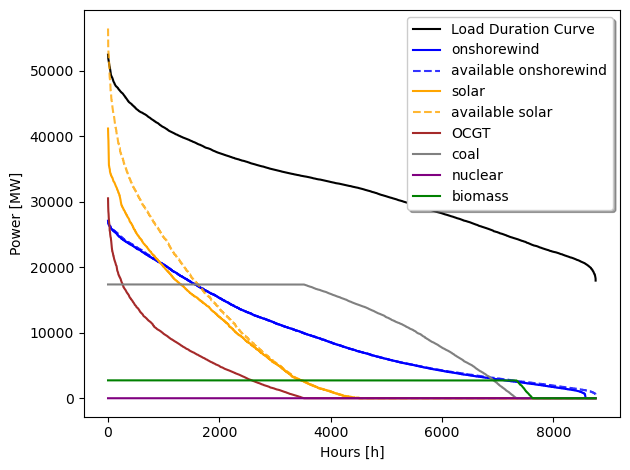

In [24]:
LDC = network.loads_t.p_set.sort_values(by=f'{country} electricity load', ascending=False) # MWh
LDC_idx = range(1,len(LDC)+1) # hours

CF_sorted_dict = {tech: CF_dict[tech].sort_values(ascending=False) for tech in VRE_techs}

plt.plot(LDC_idx,
         LDC,
         label='Load Duration Curve',
         color='black')
for tech, color in zip(techs_labels, techs_colors):
    plt.plot(LDC_idx,
               network.generators_t.p[tech].sort_values(ascending=False),
               color=color,
               label=tech)
    if tech in VRE_techs:
        plt.plot(LDC_idx,
                 network.generators.p_nom_opt[tech] * CF_sorted_dict[tech],
                 label=f"available {tech}",
                 linestyle='--',
                 alpha=0.8,
                 color=color)
        
plt.xlabel('Hours [h]')
plt.ylabel('Power [MW]')
plt.tight_layout()
plt.legend(fancybox=True, shadow=True, loc='best', prop={'size': 10})
plt.show()


# B: Sensitivity to global CO2 constraint

### Investigate how sensitive the optimum capacity mix is to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer to the emissions allowance to that historical data.

In [25]:
# The model is run multiple times with different CO2 constraints 
# corresponding to historical emissions and targets

network_B = network.copy(network.snapshots)

# Add the CO2 constraint:
network_B.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=10**10,
    overwrite=True
)

# Define limits in MtCO2: numbers are for "Electricity and heat producers" from https://www.iea.org/countries/united-kingdom/emissions
# Define limits in MtCO2: numbers include heat because they are for "Energy and Utilities" from https://klimaraadet.dk/da/klima-i-tal
global_CO2_limits = [189,  # 2000
                     68,   # 2022
                     3,    # 2022 CO2 emissions of a country with similar population size but low emissions: Tanzania
                     0]    # CO2-neutral

# Run the model
sensitivity_obj = {}
sensitivity_emis = {}
sensitivity_prod = {}
sensitivity_caps = {}
sensitivity_CO2price = {}
for co2_limit in global_CO2_limits:
    network_B.global_constraints.loc["CO2Limit", "constant"] = co2_limit * 1e6 # tCO2
    network_B.optimize(solver_name='gurobi', solver_options={"env": env})
    sensitivity_obj[co2_limit] = network_B.objective / 1e6 # € -> M€
    sensitivity_emis[co2_limit] = (
                                    network_B.generators_t.p
                                    / network_B.generators.efficiency
                                    * network_B.generators.carrier.map(network_B.carriers.co2_emissions)
                                  ).T.groupby(
                                      network_B.generators.carrier
                                  ).sum().T.sum().div(1e6).sum()  # tCO2 -> MtCO2
    sensitivity_prod[co2_limit] = [network_B.generators_t.p[tech].sum()
                                   for tech in techs_labels]
    sensitivity_caps[co2_limit] = network_B.generators.p_nom_opt.copy() # in MW
    sensitivity_CO2price[co2_limit] = - network_B.global_constraints.mu.values[0] # in €/kgCO2, '.values[0]' is simply formatting

Index(['GBR electricity load'], dtype='object', name='Load')
Index(['GBR electricity bus'], dtype='object', name='Bus')
Index(['GBR electricity load'], dtype='object', name='Load')
Index(['GBR electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]
INFO:linopy.io: Writing time: 2.38s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113888 duals
Objective: 1.83e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['GBR electricity load'], dtype='object', name='Load')
Index(['GBR electricity bus'], dtype='object', name='Bus')
Index(['GBR electricity load'], dtype='object', name='Load')
Index(['GBR electricity bus'], dtype='

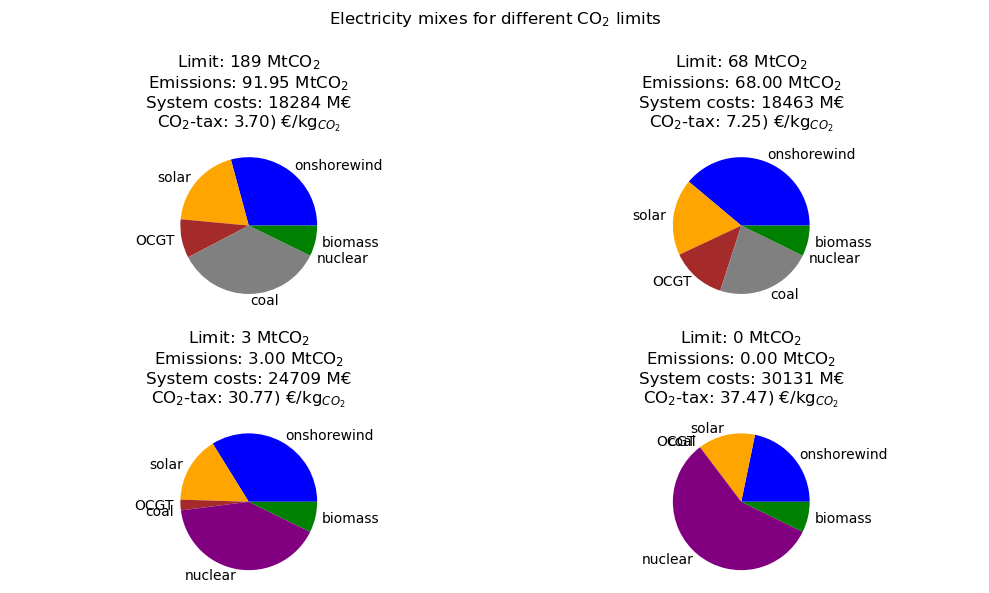

In [26]:

# Plot the results:
fig, ax = plt.subplots(2,2,figsize=(10,6))#, constrained_layout=True)
ax = ax.flatten()

for i,co2_limit in enumerate(global_CO2_limits):
    sizes = sensitivity_prod[co2_limit]
    ax[i].pie(sizes,
            colors=techs_colors,
            labels=techs_labels,
            wedgeprops={'linewidth':0})
    ax[i].axis('equal')

    ax[i].set_title(f'Limit: {co2_limit} MtCO$_2$\nEmissions: {sensitivity_emis[co2_limit]:.2f} MtCO$_2$\nSystem costs: {sensitivity_obj[co2_limit]:.0f} M€\nCO$_2$-tax: {sensitivity_CO2price[co2_limit]:.2f})'+' €/kg$_{CO_2}$', y=1.1)
plt.suptitle('Electricity mixes for different CO$_2$ limits')
plt.tight_layout()

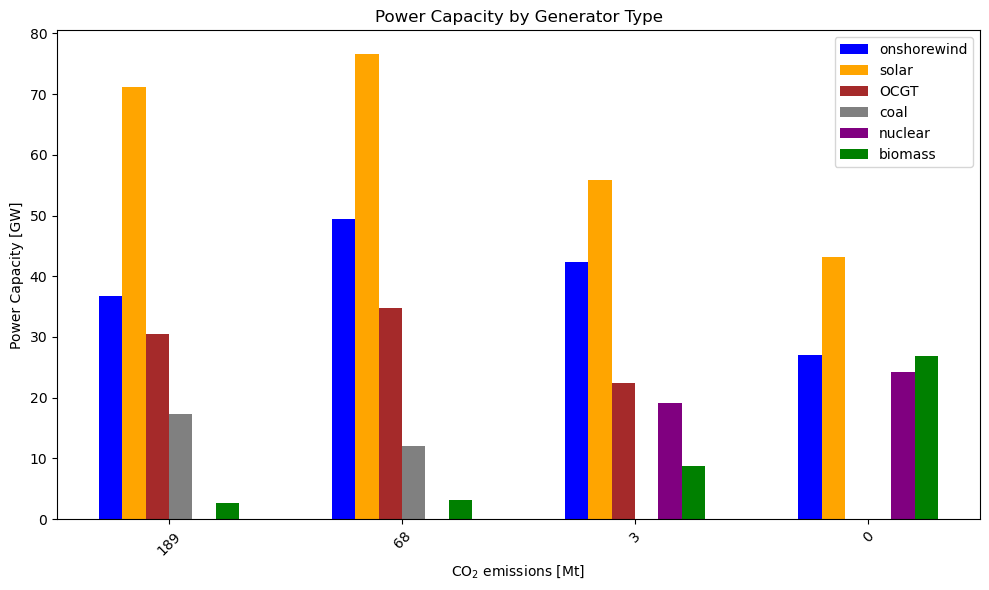

In [27]:
# Plot bars:
xticks_spacing = 1.5
x = np.arange(len(global_CO2_limits)) * xticks_spacing  # X positions
width = 0.15  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))

for i,tech in enumerate(techs_labels):
    ax.bar(x + i * width, [sensitivity_caps[co2_limit][tech]/1e3 for co2_limit in global_CO2_limits], width, color=techs_colors[i], label=tech)

# Formatting:
ax.set_xticks(x + width * (len(techs_labels) / 2 - 0.5))
ax.set_xticklabels([str(limit) for limit in global_CO2_limits])
ax.set_xlabel("CO$_2$ emissions [Mt]")
ax.set_ylabel("Power Capacity [GW]")
ax.set_title("Power Capacity by Generator Type")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

Notice, that it is required to overinvest huge amounts of money in biomass capacity even though the amount of electricity is entirely unchanged from 189 to 0 Mt (as seen in the pie charts above).

# C: Sensitivity to interannual variability of solar and wind generation

### Investigate how sensitive your results are to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years.

In [28]:
# 1) Repeat the code from B but where we reinitialize the CO2 limit to be unconstrained
# 2) Load new data files for solar and wind

# D: Add storage technologies - diurnal and seasonal
### Add some storage technology/ies and investigate how they behave and what their impact is on the optimal system configuration. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.)

In [29]:
network_D = network.copy(network.snapshots)
network.objective / 10**9, network_B.objective / 10 ** 9

(18.283725722035733, 30.1313989874686)

In [30]:
# All capital costs are from the 2025 version of the 
# Technology Catalogue for 'Energy Storage' (DEA)
# https://ens.dk/en/analyses-and-statistics/technology-catalogues

# StorageUnits:
# Molten salt carnot battery '143b'
# Li-ion '180'
# Vanadium redox battery '181'

techs_labels_storageunits = ['Carnot battery (Molten salt)', 'Li-ion battery', ' Vanadium rfb']
Crates = np.array([120/800, 3.5/7, 0.5/2]) # MW / MWh
capital_costs_storageunits_MWh = np.array([0.063, 0.66, 0.37]) * 1e6 # M€/MWh
capital_costs_storageunits = capital_costs_storageunits_MWh / Crates # M€/MW
lifetimes_storageunits = np.array([25, 25, 20]) # years
dict_capital_costs_annualized_storageunits = {
    storage:f.annuity(lifetime, 0.07)*cost*(1+0.03)
    for storage, cost, lifetime in zip(techs_labels_storageunits,
                                       capital_costs_storageunits,
                                       lifetimes_storageunits)
    }

efficiencies_in = {storage: eff for storage, eff in zip(techs_labels_storageunits,
                                                        [np.sqrt(0.3),
                                                         np.sqrt(0.92),
                                                         np.sqrt(0.78)])}
efficiencies_out = {storage: eff for storage, eff in zip(techs_labels_storageunits,
                                                        [np.sqrt(0.3),
                                                         np.sqrt(0.92),
                                                         np.sqrt(0.78)])}
hourly_losses = {storage: loss for storage, loss in zip(techs_labels_storageunits,
                                                        np.array([0.9,
                                                                  0.1,
                                                                  0.0])/100/24)}
# the above units are converted [%/day] * 1/100/24 -> [p.u./h]
# no standing losses are given for the Vanadium redox flow battery...

# add the storage units
for i, storage in enumerate(techs_labels_storageunits):
    network_D.add("StorageUnit",
                    storage,
                    bus=f"{country} electricity bus",
                    p_nom_extendable=True,
                    carrier="electricity",
                    capital_cost=dict_capital_costs_annualized_storageunits[storage],
                    efficiency_store=efficiencies_in[storage],
                    efficiency_dispatch=efficiencies_out[storage],
                    max_hours=1/Crates[i],
                    cyclic_state_of_charge=True,
                    standing_loss=hourly_losses[storage],  # <- this value quantitatively indicates whether storage is diurnal/seasonal
                    overwrite=True) # for re-running the code
# network_D.storage_units

In [31]:
network_D.optimize(solver_name='gurobi', solver_options={"env": env})

print("System costs in b€:", network_D.objective / 10**9) #in 10^9 €
print("GENERATOR capacities in GW: ", network_D.generators.p_nom_opt.div(1e3) ) # in GW
print("STORAGE capacities in GW: ", network_D.storage_units.p_nom_opt.div(1e3) ) # in GW

Index(['Carnot battery (Molten salt)', 'Li-ion battery', ' Vanadium rfb'], dtype='object', name='StorageUnit')
Index(['GBR electricity load'], dtype='object', name='Load')
Index(['GBR electricity bus'], dtype='object', name='Bus')
Index(['Carnot battery (Molten salt)', 'Li-ion battery', ' Vanadium rfb'], dtype='object', name='StorageUnit')
Index(['GBR electricity load'], dtype='object', name='Load')
Index(['GBR electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00,  9.23it/s]
INFO:linopy.io: Writing time: 3.75s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131409 primals, 297850 duals
Objective: 1.81e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lo

System costs in b€: 18.08321822008243
GENERATOR capacities in GW:  Generator
onshorewind    39.318033
solar          85.979651
OCGT           21.620016
coal           16.065420
nuclear         0.000000
biomass         2.895866
Name: p_nom_opt, dtype: float64
STORAGE capacities in GW:  StorageUnit
Carnot battery (Molten salt)    10.925831
Li-ion battery                   0.000000
 Vanadium rfb                    0.000000
Name: p_nom_opt, dtype: float64


Text(0.5, 1.07, 'Electricity mix')

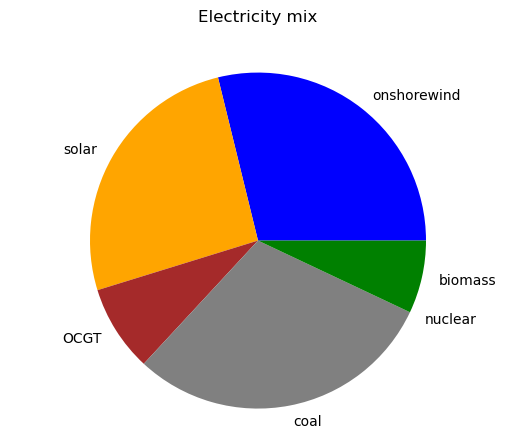

In [32]:
sizes_D = [network_D.generators_t.p[tech].sum()
         for tech in techs_labels]

plt.pie(sizes_D,
        colors=techs_colors,
        labels=techs_labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [41]:
np.array(sizes_D) / 10**6, biomass_available / 10**6 * dict_efficiencies['biomass'] # in TWh. Compare the biomass used to the biomass available to verify if we are using everything


(array([83.90573137, 75.49360953, 24.25250345, 86.97160827,  0.        ,
        20.41308631]),
 20.413086308278803)

In [33]:
# Generator revenues and expenditures
print(network_D.generators_t.p.multiply(network_D.buses_t.marginal_price.to_numpy()).sum().div(1e6))
# Total expenditures by carriers
print(
( network_D.statistics.capex(groupby="carrier").add(
    network_D.statistics.opex(groupby="carrier"), fill_value=0
    )
).div(1e6) # € -> M€
)

Generator
onshorewind    4350.317221
solar          1975.817243
OCGT           3018.249948
coal           7082.775026
nuclear           0.000000
biomass        1483.525757
dtype: float64
component    carrier    
Generator    coal           7082.775026
             gas            3018.249948
             onshorewind    4350.317221
             solar          1975.817243
             wood chips     1250.474124
StorageUnit  electricity     405.584658
dtype: float64


In [34]:
# Storage units revenues and expenditures
print(network_D.storage_units_t.p.multiply(network_D.buses_t.marginal_price.to_numpy()).sum().div(1e6)) # € -> M€
[network_D.storage_units.p_nom_opt[storage]
 * dict_capital_costs_annualized_storageunits[storage]
 / 10**6 for storage in techs_labels_storageunits] # € -> M€

StorageUnit
Carnot battery (Molten salt)    405.584658
Li-ion battery                    0.000000
 Vanadium rfb                     0.000000
dtype: float64


[405.58465828685183, 0.0, 0.0]

In [35]:
# emissions by CARRIER
emissions = (
    network_D.generators_t.p
    / network_D.generators.efficiency
    * network_D.generators.carrier.map(network_D.carriers.co2_emissions)
).T.groupby(network_D.generators.carrier).sum().T  # t/h
emissions.sum().div(1e6), emissions.sum().div(1e6).sum()  # tCO2 -> MtCO2

(carrier
 coal           71.232122
 gas            10.184935
 nuclear         0.000000
 onshorewind     0.000000
 solar           0.000000
 wood chips      0.000000
 dtype: float64,
 81.41705679664344)

# Daily patterns

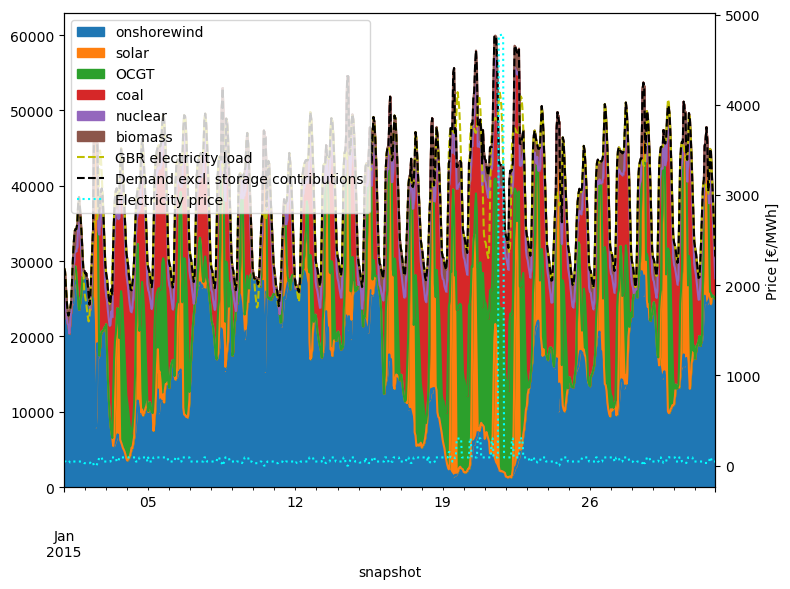

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
ax2 = ax.twinx()

network_D.generators_t.p.loc["2015-01"].plot.area(ax=ax, label="generators dispatch")
network_D.loads_t.p.loc["2015-01"].plot(ax=ax, linestyle='--', color='y', label="demand")
(network_D.loads_t.p.loc["2015-01"][f'{country} electricity load']
 - network_D.storage_units_t.p.loc["2015-01"].T.sum()
 ).plot(ax=ax, linestyle='--', color='k', label="Demand excl. storage contributions")

network_D.buses_t.marginal_price.loc["2015-01"][f"{country} electricity bus"].plot(ax=ax2, linestyle=':', color='cyan', label="Electricity price", legend=False)
ax2.set_ylabel('Price [€/MWh]')
# ax2.set_ylim([0,70]) # -> uncomment to see prices properly

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

#ax2.get_legend().remove() if ax2.get_legend() else None
ax.legend(h1+h2, l1+l2, loc="upper left")
plt.tight_layout()
plt.show()

### Before, the total generation was equal to the demand, though this is no longer the case because the storage technologies are not 100% efficient

In [37]:
print("Total generation before: ", network.generators_t.p.sum().div(1e6).sum(), " TWh")
print("Total generation after: ", network_D.generators_t.p.sum().div(1e6).sum(), " TWh")
print("Total demand: ", network.loads_t.p.sum().div(1e6).sum(), " TWh")

Total generation before:  282.19518899999997  TWh
Total generation after:  291.03653892973347  TWh
Total demand:  282.195189  TWh


In [38]:
network.generators_t.p.sum().div(1e6), network_D.generators_t.p.sum().div(1e6) # TWh

(Generator
 onshorewind    82.823974
 solar          54.095840
 OCGT           25.846064
 coal           99.016225
 nuclear         0.000000
 biomass        20.413086
 dtype: float64,
 Generator
 onshorewind    83.905731
 solar          75.493610
 OCGT           24.252503
 coal           86.971608
 nuclear         0.000000
 biomass        20.413086
 dtype: float64)

# Use patterns

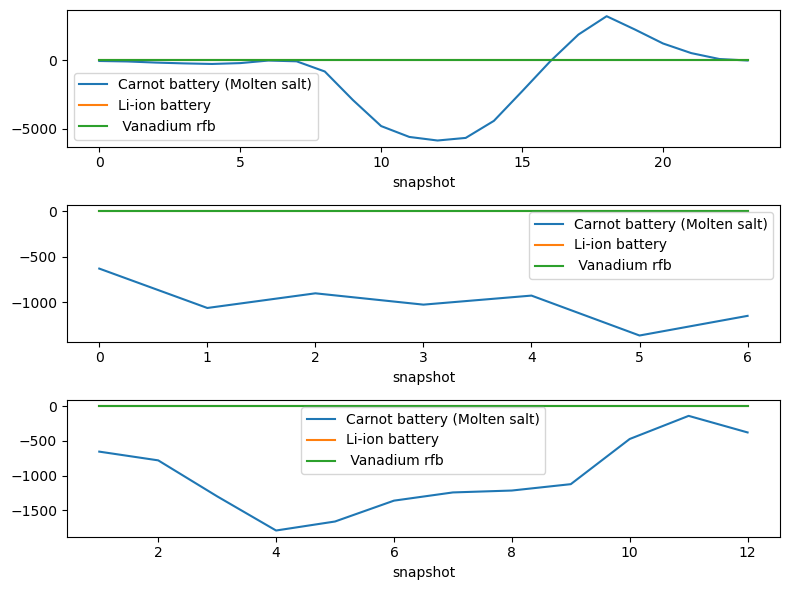

In [39]:
fig, ax = plt.subplots(3,1,figsize=(8,6))

hourly_idx=pd.to_datetime(network_D.storage_units_t.p.index).hour
daily_idx=pd.to_datetime(network_D.storage_units_t.p.index).day_of_week
monthly_idx=pd.to_datetime(network_D.storage_units_t.p.index).month

dict_idx = {
    "hourly": hourly_idx,
    "daily": daily_idx,
    "monthly": monthly_idx
}

for i, idx in enumerate(dict_idx):
    network_D.storage_units_t.p.groupby(dict_idx[idx]).mean().plot(ax=ax[i], linewidth=1.5, label="storage (production)")
    ax[i].legend()
plt.tight_layout()
plt.show()

##### **HOURLY**: There's a very clear hourly pattern.

##### **DAILY**: Maybe there is a slight tendency towards charging more in the weekend to prepare for Monday

##### **MONTHLY**: It seems that the battery may be charged through the Spring months and then discharged in October-November, however, this is not entirely clear from the plot above. In fact, when we consider the hourly loss of the Carnot battery, this actually sounds a little off. It is verified below that there is NO seasonal pattern.

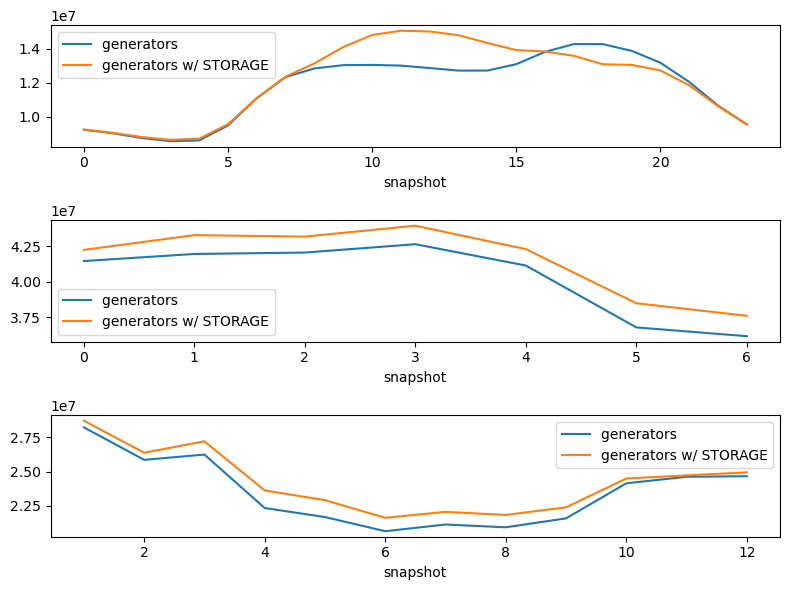

In [40]:
# Compare the generation before and after allowing storage:
fig, ax = plt.subplots(3,1,figsize=(8,6))

for i, idx in enumerate(dict_idx):
    network.generators_t.p.groupby(dict_idx[idx]).sum().T.sum().plot(ax=ax[i], linewidth=1.5, label="generators ", legend=False)
    network_D.generators_t.p.groupby(dict_idx[idx]).sum().T.sum().plot(ax=ax[i], linewidth=1.5, label="generators w/ STORAGE", legend=False)
    ax[i].legend()
plt.tight_layout()
plt.show()

# E:
### Select one target for decarbonization (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your results.

# F -> done in another file
### Connect your country with, at least, two neighbouring countries. 
You can connect them using HVAC lines, HVDC links or gas pipelines. Use a linear representation of power flow or gas flow. 
You can assume that the generation capacities in the neighbouring countries are fixed or optimize the whole system. You can also include fixed interconnection capacities or optimize them with the generators' capacities. Discuss your results.

#### **We connect GBR to France and Norway**